<a href="https://colab.research.google.com/github/GabrielFranciscoSM/Hojas_con_resfriado_placeholder/blob/main/notebooks/AppleTreeLeaf_YOLO.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Apple Tree Leaf Disease

In [ ]:
from google.colab import drive
import os

# We start by getting access to the drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


## Extracción de Bounding Boxes

En primer lugar tomaremos una muestra de una imágen junto a su correspondiente máscara de segmentación para determinar cómo extraer las _bounding boxes_

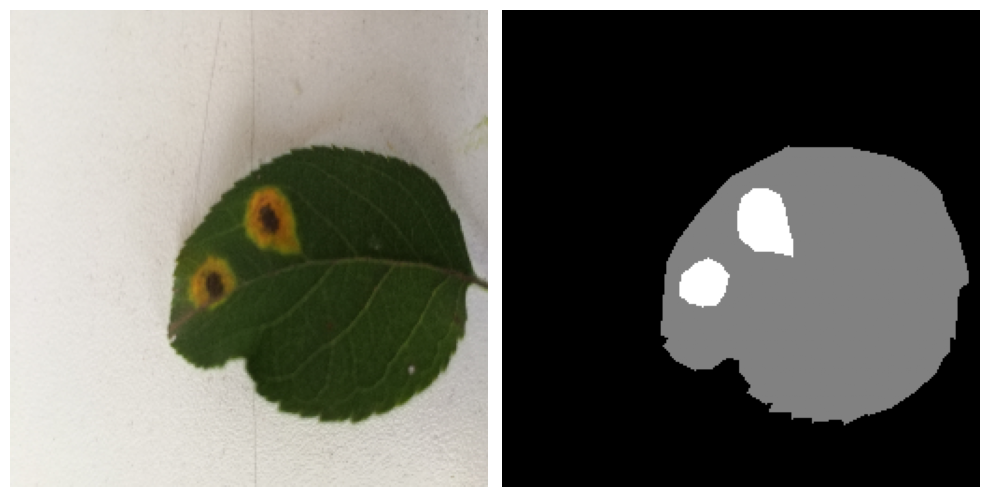

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import torch

get_image = lambda route: os.path.join('/content/drive/MyDrive/AppleTreeLeafDisease', route)

img = cv2.imread(get_image("Rust/image/IMG_20190727_164455.jpg"))
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

mask = cv2.imread(get_image("Rust/label/IMG_20190727_164455.png"))
mask = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)

plt.figure(figsize=(10,10))
plt.subplot(1, 2, 1)
plt.imshow(img)
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(mask, cmap="gray")
plt.axis('off')

plt.tight_layout()
plt.show()

A pesar de que existen varias alternativas optamos por utilizar exclusivamente la librería de OpenCV

In [ ]:
def extract_bounding_boxes(img, mask):
  # Retrieve the unique colors, as these would be the object ids
  obj_ids = np.unique(mask)

  # First id is the background, so remove it
  obj_ids = obj_ids[1:]

  boxes = []
  output_img = img.copy()

  for id in obj_ids:
    # Create binary mask for this specific class
    binary_mask = (mask == id).astype(np.uint8) * 255

    # Extract countours
    contours, _ = cv2.findContours(binary_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    for cnt in contours:
      # Get the box coordinates
      x, y, w, h = cv2.boundingRect(cnt)

      # Store them (optional, if you need the data)
      boxes.append([x, y, w, h])

      # Draw rectangle on image (Color: Red, Thickness: 2)
      cv2.rectangle(output_img, (x, y), (x + w, y + h), (255, 0, 0), 2)

  return boxes, output_img

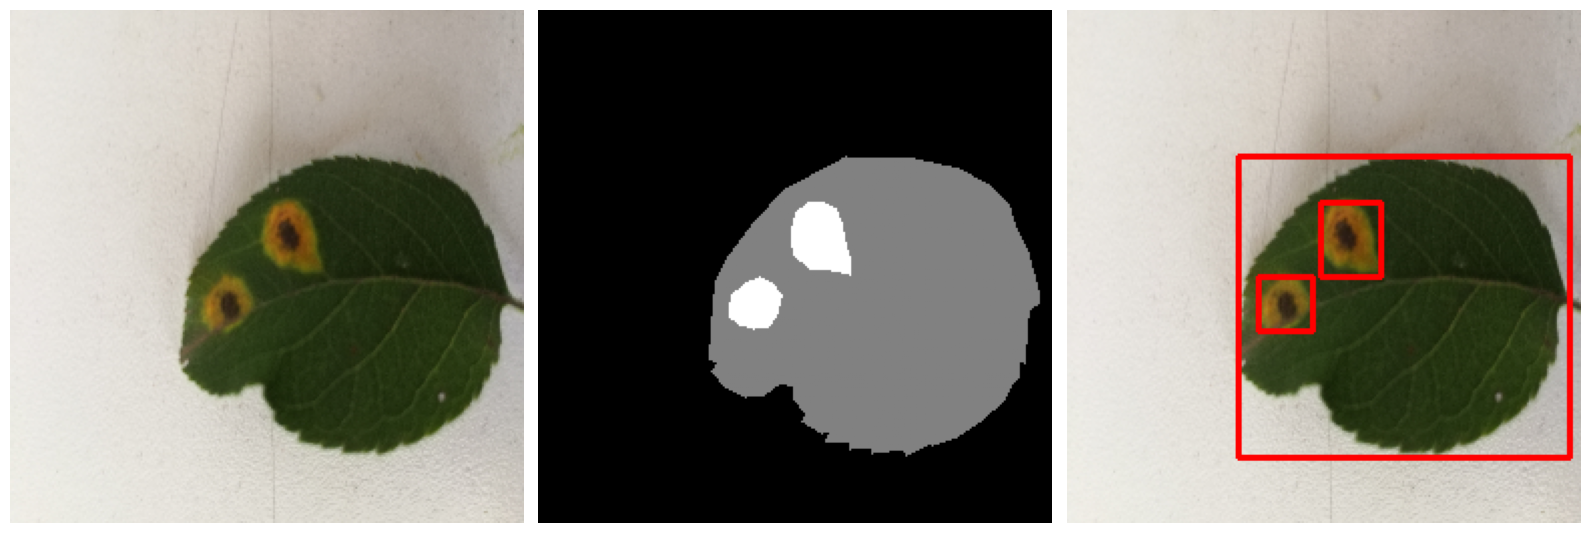

In [ ]:
bb, bb_img = extract_bounding_boxes(img, mask)

plt.figure(figsize=(16, 10))

plt.subplot(1, 3, 1)
plt.imshow(img)
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(mask, cmap="gray")
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(bb_img)
plt.axis('off')

plt.tight_layout()
plt.show()

Ya que la idea del proyecto es realizar la clasificación del tipo de planta de forma preliminar, solo nos hará falta las _bounding boxes_ de las posibles enfermedades. Para ello, vamos a tener que hacer uso de la codificación en colores que trae las máscaras puesto que, para hojas sanas, la codificación en blanco y negro induce a errores en la selección

In [ ]:
def visualize_rgb_bw_mask(img_path, mask_path):
  img = cv2.imread(get_image(img_path))
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

  mask = cv2.imread(get_image(mask_path))
  bw_mask = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)
  rgb_mask = cv2.cvtColor(mask, cv2.COLOR_BGR2RGB)

  plt.figure(figsize=(10,10))
  plt.subplot(1, 3, 1)
  plt.imshow(img)
  plt.axis('off')

  plt.subplot(1, 3, 2)
  plt.imshow(rgb_mask)
  plt.axis('off')

  plt.subplot(1, 3, 3)
  plt.imshow(bw_mask, cmap="gray")
  plt.axis('off')

  plt.tight_layout()
  plt.show()

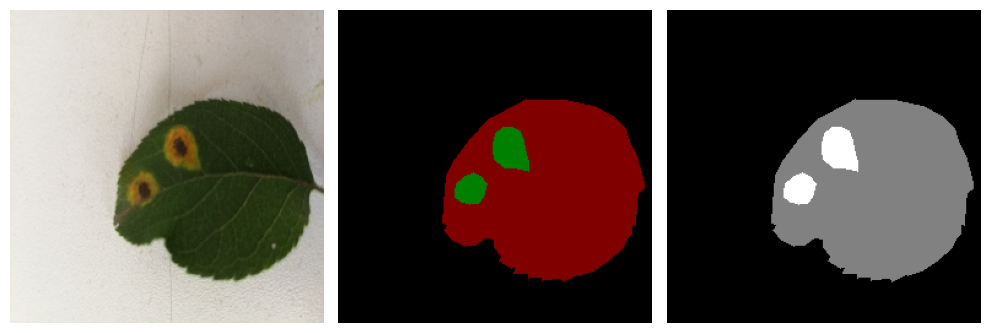

In [ ]:
visualize_rgb_bw_mask("Rust/image/IMG_20190727_164455.jpg", "Rust/label/IMG_20190727_164455.png")

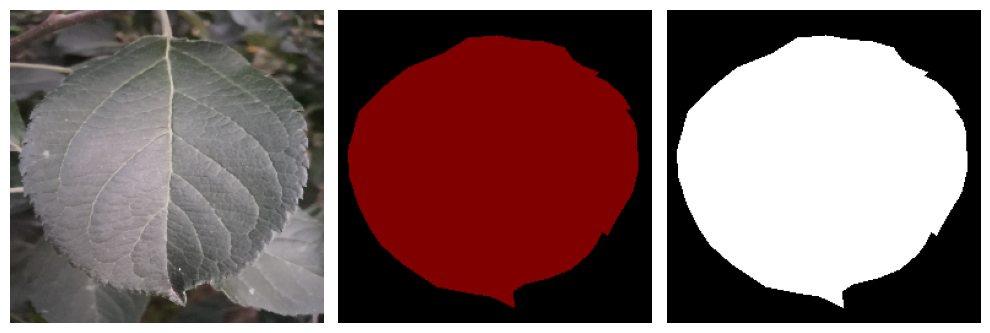

In [ ]:
visualize_rgb_bw_mask("Healthy_Leaf/image/IMG_20190726_200540.jpg", "Healthy_Leaf/label/IMG_20190726_200540.png")

Como se puede observar, en el caso de las hojas sanas, la codificación en RGB es consistente con la separación entre la hoja y la enfermedad, mientras que la codificación en BW no lo es. Para ello, optaremos por determinar los tres colores utilizados en la codificación RGB para seleccionar aquellas regiones con el color que nos interesa (en nuestro caso será el verde)

In [ ]:
mask = cv2.imread(get_image("Rust/label/IMG_20190727_164455.png"))
mask = cv2.cvtColor(mask, cv2.COLOR_BGR2RGB)

# Reshape the 3D mask array (height, width, channels) to a 2D array (pixels, channels)
reshaped_mask = mask.reshape(-1, mask.shape[-1])

# Find unique rows (which are the unique RGB colors) along axis 0
unique_rgb_colors = np.unique(reshaped_mask, axis=0)

print(f"Unique RGB colors found in the mask:\n\n{unique_rgb_colors}")

Unique RGB colors found in the mask:

[[  0   0   0]
 [  0 128   0]
 [128   0   0]]


A continuación mostramos implementada una clase con todo el procesamiento de las imágenes.

In [ ]:
class ImageProcessor:
  def __init__(self):
    self.img = None

  def load_img(self, img_path):
    """
    Load image to paint bounding boxes in it
    """
    self.img = cv2.imread(img_path)
    self.img = cv2.cvtColor(self.img, cv2.COLOR_BGR2RGB)

  def clean_mask(self, mask_path):
    """
    Extract disease binary mask from RGB mask.
    """
    mask_bgr = cv2.imread(mask_path)
    if mask_bgr is None:
      return None

    rgb = cv2.cvtColor(mask_bgr, cv2.COLOR_BGR2RGB)

    # Background and Leaf colors
    black = np.array([0, 0, 0])
    red = np.array([128, 0, 0])

    # Extract masks for Background and Leaf sections
    mask_black = cv2.inRange(rgb, black, black)
    mask_red = cv2.inRange(rgb, red, red)

    # Extract the disease mask from those
    to_remove = cv2.bitwise_or(mask_black, mask_red)
    disease_mask = cv2.bitwise_not(to_remove)

    return disease_mask

  def get_bounding_boxes(self, binary_mask, class_id):
    """
    Compute YOLO bounding boxes from a binary mask.
    Returns a list of strings in the format: 'class_id x_norm y_norm w_norm h_norm'
    """
    img_h, img_w = binary_mask.shape

    contours, _ = cv2.findContours(binary_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    yolo_lines = []
    for cnt in contours:
      # Filter noise
      if cv2.contourArea(cnt) > 20:
        # Get the box coordinates
        x, y, w, h = cv2.boundingRect(cnt)

        if self.img is not None:
          # Draw rectangle on image (Color: Red, Thickness: 2)
          cv2.rectangle(self.img, (x, y), (x + w, y + h), (255, 0, 0), 2)

        # Compute center
        center_x = x + (w / 2.0)
        center_y = y + (h / 2.0)

        # Normalize
        nx = center_x / img_w
        ny = center_y / img_h
        nw = w / img_w
        nh = h / img_h

        # Clamping
        nx = min(max(nx, 0), 1)
        ny = min(max(ny, 0), 1)
        nw = min(max(nw, 0), 1)
        nh = min(max(nh, 0), 1)

        # Format string
        line = f"{class_id} {nx:.6f} {ny:.6f} {nw:.6f} {nh:.6f}"
        yolo_lines.append(line)

    return yolo_lines

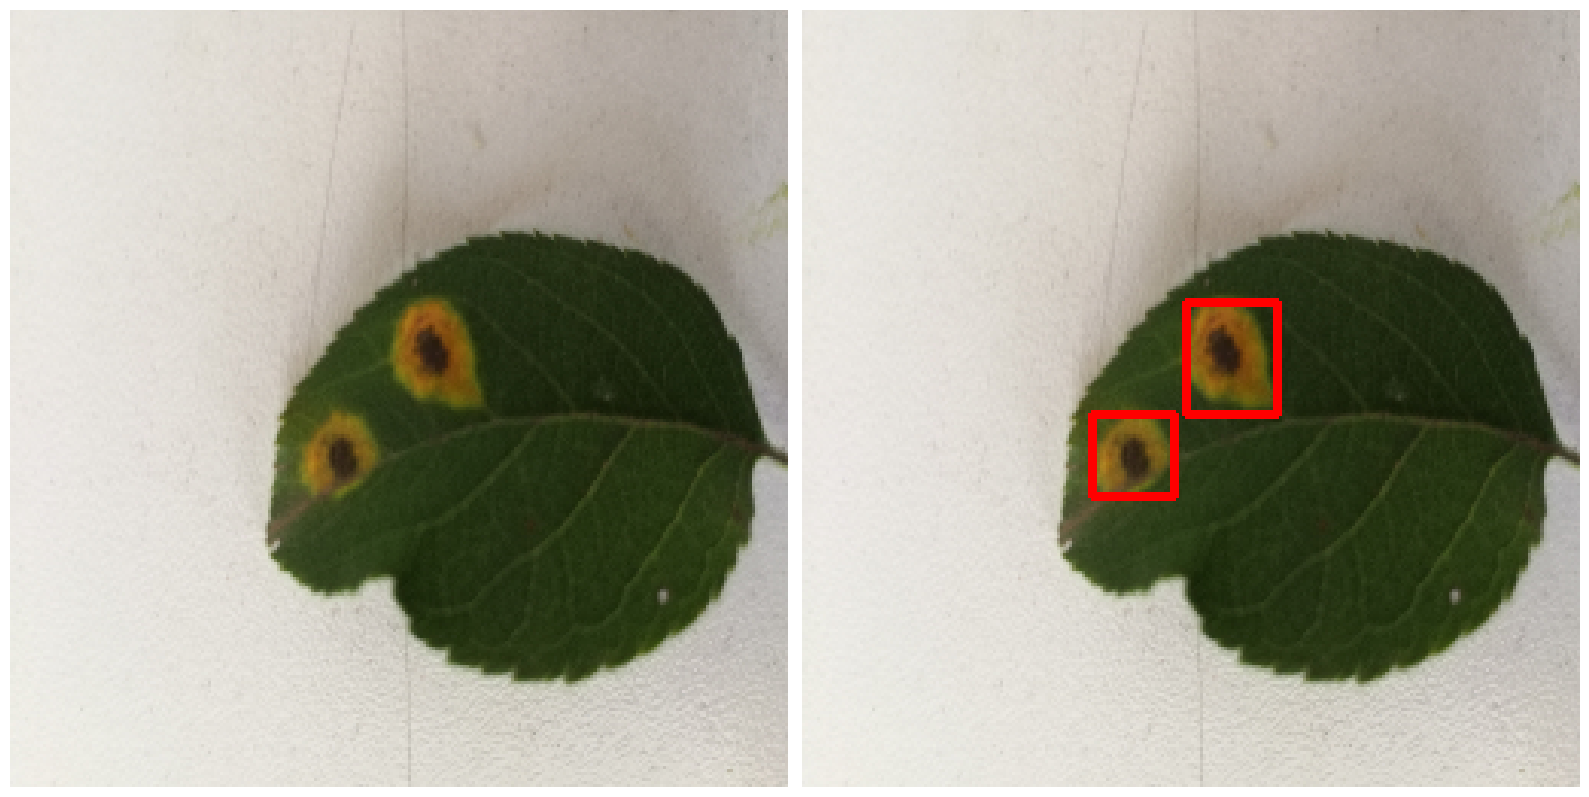

In [ ]:
processor = ImageProcessor()

# Load image into the processor
processor.load_img(get_image("Rust/image/IMG_20190727_164455.jpg"))

plt.figure(figsize=(16, 10))

plt.subplot(1, 2, 1)
plt.imshow(processor.img)
plt.axis('off')

# Get mask and compute the bounding boxes
mask = processor.clean_mask(get_image("Rust/label/IMG_20190727_164455.png"))
yolo = processor.get_bounding_boxes(mask, 0)

plt.subplot(1, 2, 2)
plt.imshow(processor.img)
plt.axis('off')

plt.tight_layout()
plt.show()

Dichos _bounding boxes_ tienen las siguientes coordenadas

In [ ]:
yolo

['0 0.423828 0.572266 0.105469 0.105469',
 '0 0.550781 0.447266 0.117188 0.144531']

## Exploración del Dataset

Seguidamente será necesario extraer tuplas de la forma `(class, img, mask)` de la estructura de directorios en la que está almacenado el _dataset_.

In [ ]:
from pathlib import Path

root = Path("/content/drive/MyDrive/AppleTreeLeafDisease")
valid_ext = [".jpg", ".png"]

dataset = []
classes = {}

# Each directory wraps a different disease
dirs = sorted([d for d in root.iterdir() if d.is_dir()])
for i, disease in enumerate(dirs):
  image_dir = disease / "image"
  mask_dir = disease / "label"

  # Check if both subdirectories exist
  if image_dir.exists() and mask_dir.exists():

    # Add disease to the class list
    classes[disease.name] = i

    # Extract images and masks
    images = sorted([f for f in image_dir.iterdir() if f.suffix.lower() in valid_ext])
    masks = sorted([f for f in mask_dir.iterdir() if f.suffix.lower() in valid_ext])

    # Dictionary of masks for fast lookup by filename
    mask_dict = {mask.stem: mask for mask in masks}

    for image_path in images:
      # Check if a label with the same name exists
      if image_path.stem in mask_dict:
        dataset.append((i, image_path, mask_dict[image_path.stem]))
      else:
        print(f"No mask found for {image_path.stem}")

print(f"Found {len(dataset)} pairs.")

Found 1641 pairs.


De esta forma hemos obtenido $1641$ tuplas de las siguientes clases

In [ ]:
classes

{'Alternaria_Leaf_Spot': 0,
 'Brown_Spot': 1,
 'Gray_Spot': 2,
 'Healthy_Leaf': 3,
 'Rust': 4}

Así, podemos automatizar la extracción de las _bounding boxes_

In [ ]:
from random import sample

def show_sample(dataset_pairs, n):
  samples = sample(dataset_pairs, n)

  fig, axs = plt.subplots(n, 3, figsize=(6, 10))

  for i, (class_id, img_path, mask_path) in enumerate(samples):
    processor = ImageProcessor()
    processor.load_img(img_path)

    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    mask = cv2.imread(mask_path)
    mask = cv2.cvtColor(mask, cv2.COLOR_BGR2RGB)

    cleaned_mask = processor.clean_mask(mask_path)
    yolo = processor.get_bounding_boxes(cleaned_mask, class_id)

    axs[i, 0].imshow(img)
    axs[i, 0].axis('off')

    axs[i, 1].imshow(mask)
    axs[i, 1].axis('off')

    axs[i, 2].imshow(processor.img)
    axs[i, 2].axis('off')

  plt.tight_layout()
  plt.show()

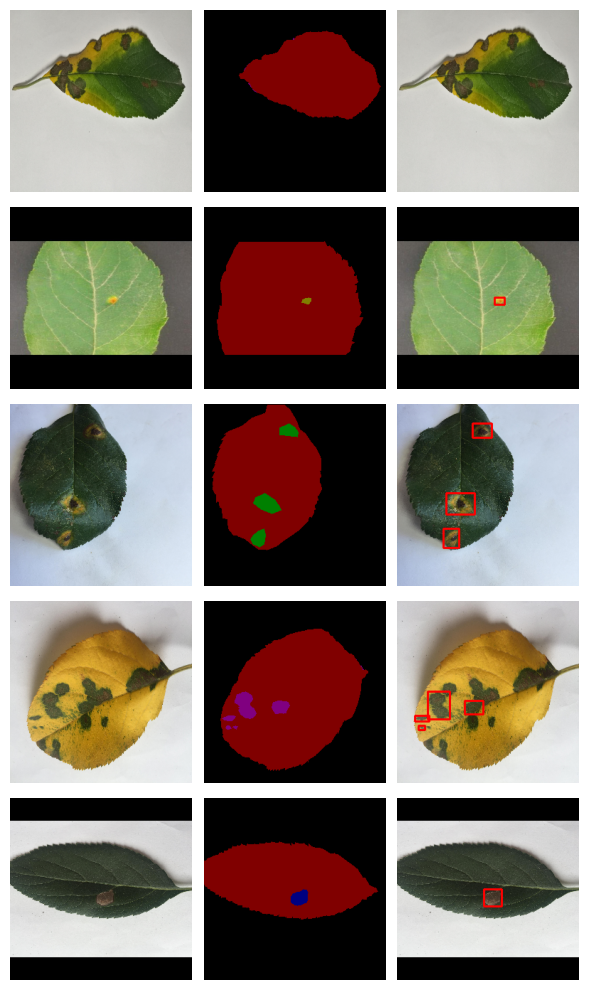

In [ ]:
show_sample(dataset, 5)

## Reestructuración de directorios para YOLO

Para cada imagen necesitaremos guardar un archivo `.txt` con las respectivas _bounding boxes_. Además, la implementación de YOLO requiere tanto que separemos las imágenes en dos directorios (`train`, `test`) como un archivo `.yaml` donde se especifican el número de clases, los nombres de las clases y las rutas a dichos directorios.

Unificaremos todas estas utilidades bajo la clase `DatasetBuilder`

In [ ]:
import shutil
import yaml

class DatasetBuilder:
  def __init__(self, output_path):
    self.output_path = output_path
    self.processor = ImageProcessor()
    self.classes = {}

  def prepare_directories(self):
    """
    Creates the directory structure for YOLO
    """

    # If it already exist delete it
    if os.path.exists(self.output_path):
      shutil.rmtree(self.output_path)

    for split in ['train', 'val']:
      os.makedirs(f"{self.output_path}/{split}/images", exist_ok=True)
      os.makedirs(f"{self.output_path}/{split}/labels", exist_ok=True)

  def scan_dataset(self, source_root):
    """
    Scans the whole dataset and extracts the classes, images and masks
    """
    dataset = []

    # Each directory wraps a different disease
    dirs = sorted([d for d in source_root.iterdir() if d.is_dir()])
    for i, disease in enumerate(dirs):
      image_dir = disease / "image"
      mask_dir = disease / "label"

      # Check if both subdirectories exist
      if image_dir.exists() and mask_dir.exists():

        # Add disease to the class list
        self.classes[disease.name] = i

        # Extract images and masks
        images = sorted([f for f in image_dir.iterdir() if f.is_file()])
        masks = sorted([f for f in mask_dir.iterdir() if f.is_file()])

        # Dictionary of masks for fast lookup by filename
        mask_dict = {mask.stem: mask for mask in masks}

        for image_path in images:
          # Check if a label with the same name exists
          if image_path.stem in mask_dict:
            dataset.append((i, image_path, mask_dict[image_path.stem]))
          else:
            print(f"[!] No mask found for {image_path.stem}")

    print(f"[+] Found {len(self.classes)} classes and {len(dataset)} images")
    return dataset

  def process_subset(self, subset, split):
    """
    Processes a subset (train or val) and saves the YOLO file
    """
    print(f"[+] Processing {split.upper()} containing {len(subset)} images...")

    count = 0
    for class_id, img_path, mask_path in subset:
      # Copy the original image into the destination directory
      dst_img_path = self.output_path / split / "images" / img_path.name
      shutil.copy(img_path, dst_img_path)

      # Process mask
      cleaned_mask = self.processor.clean_mask(mask_path)

      if cleaned_mask is not None:
        # Obtain bounding boxes
        yolo_lines = self.processor.get_bounding_boxes(cleaned_mask, class_id)

        # Save .txt file for YOLO
        dst_txt_name = img_path.stem + ".txt"
        dst_txt_path = self.output_path / split / "labels" / dst_txt_name

        with open(dst_txt_path, 'w') as f:
          for line in yolo_lines:
            f.write(line + '\n')

        count += 1
      else:
        print(f"[!] No mask found for {img_path.stem}")

    print(f"[+] Processed {count} images in {split.upper()}")

  def create_yaml(self):
    """
    Generates the data.yaml file needed for YOLO
    """
    yaml_data = {
        "path": str(self.output_path),
        "train": "train/images",
        "val": "val/images",
        "nc": len(self.classes),
        "names": list(self.classes.keys())
    }
    with open(self.output_path / "data.yaml", 'w') as f:
      yaml.dump(yaml_data, f, sort_keys=False)

    print(f"[+] Configuration file created at {self.output_path}/data.yaml")


A continuación crearemos una nueva estructura de directorios temporal donde alojaremos el _dataset_ preparado para aplicar YOLO

In [ ]:
from sklearn.model_selection import train_test_split

# Route of the dataset
SOURCE_PATH = Path("/content/drive/MyDrive/AppleTreeLeafDisease")

# Local route for the YOLO adapted dataset
LOCAL_OUTPUT_PATH = Path("/content/AppleTreeLeafDisease_YOLO")

# Drive route for the YOLO adapted dataset
DRIVE_OUTPUT_PATH = Path("/content/drive/MyDrive/AppleTreeLeafDisease_YOLO")

# Create builder with that route as root
builder = DatasetBuilder(LOCAL_OUTPUT_PATH)

try:
  print(f"[+] Generating local dataset in {LOCAL_OUTPUT_PATH}")

  # Create local directories
  builder.prepare_directories()

  # Scan dataset
  dataset = builder.scan_dataset(SOURCE_PATH)

  # Divide images
  train_imgs, val_imgs = train_test_split(dataset, test_size=0.2, random_state=42)

  # Process each batch of images
  builder.process_subset(train_imgs, 'train')
  builder.process_subset(val_imgs, 'val')

  # Create configuration file
  builder.create_yaml()

  # Copies the whole directory structure into our Drive
  #shutil.copytree(LOCAL_OUTPUT_PATH, DRIVE_OUTPUT_PATH)

  print("[+] Dataset generated successfully!")
except Exception as e:
  print(f"\n\n[!] Error: {e}")

[+] Generating local dataset in /content/AppleTreeLeafDisease_YOLO
[+] Found 5 classes and 1641 images
[+] Processing TRAIN containing 1312 images...
[+] Processed 1312 images in TRAIN
[+] Processing VAL containing 329 images...
[+] Processed 329 images in VAL
[+] Configuration file created at /content/AppleTreeLeafDisease_YOLO/data.yaml
[+] Dataset generated successfully!


## YOLO

Ya estamos en condiciones de empezar a implementar un flujo de trabajo con YOLO. Comenzaremos instalando la biblioteca de `ultralytics` que se trata de una empresa dedicada a mantener e implementar versiones modernas de YOLO

In [ ]:
!pip install -Uqq ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 21.1 MB/s eta 0:00:00


### YOLOv3

Comenzamos realizando unas pruebas preliminares con la versión básica de YOLOv3 en `ultralytics`

In [ ]:
from ultralytics import YOLO

DATASET_PATH = Path("/content/AppleTreeLeafDisease_YOLO")
YAML_PATH = DATASET_PATH / "data.yaml"

if not DATASET_PATH.exists():
    print(f"[!] Error: Configuration file not found in {YAML_PATH}")

# Load a pretrained YOLO model
model = YOLO('yolov3.pt')

# Train the model for 3 epochs
results = model.train(
    data=YAML_PATH,
    epochs=25,
    imgsz=640,
    batch=16
)

# Evaluate the model's performance on the validation set
metrics = model.val()

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
PRO TIP 💡 Replace 'model=yolov3.pt' with new 'model=yolov3u.pt'.
YOLOv5 'u' models are trained with https://github.com/ultralytics/ultralytics and feature improved performance vs standard YOLOv5 models trained with https://github.com/ultralytics/yolov5.

Ultralytics 8.3.251 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (NVIDIA A100-SXM4-40GB, 40507MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/AppleTreeLeafDisease_YOLO/data.yaml, degrees=0.0, determ

A continuación, se muestran los resultados del entrenamiento

In [ ]:
import pandas as pd

df = pd.read_csv("/content/runs/detect/train/results.csv")
df.tail()

epoch     time  train/box_loss  train/cls_loss  train/dfl_loss  \
20     21  472.792         1.18222         0.79061         1.28520   
21     22  495.196         1.14821         0.73533         1.26150   
22     23  517.102         1.12677         0.72066         1.24465   
23     24  539.008         1.10515         0.70803         1.22655   
24     25  561.356         1.09064         0.68051         1.22333   

    metrics/precision(B)  metrics/recall(B)  metrics/mAP50(B)  \
20               0.73620            0.77299           0.76215   
21               0.70411            0.84047           0.77151   
22               0.74272            0.80110           0.76708   
23               0.71966            0.81809           0.77880   
24               0.72165            0.82509           0.78088   

    metrics/mAP50-95(B)  val/box_loss  val/cls_loss  val/dfl_loss    lr/pg0  \
20              0.49183       1.11933       2.26418       1.18999  0.000231   
21              0.48945       1.11358       1.43089       1.18656  0.000187   
22              0.48425       1.10895       1.55569       1.18492  0.000143   
23              0.50637       1.10649       1.63470       1.18126  0.000099   
24              0.49882       1.10717       2.00565       1.18187  0.000055   

      lr/pg1    lr/pg2  
20  0.000231  0.000231  
21  0.000187  0.000187  
22  0.000143  0.000143  
23  0.000099  0.000099  
24  0.000055  0.000055

Junto con las gráficas que nos provee el propio _framework_

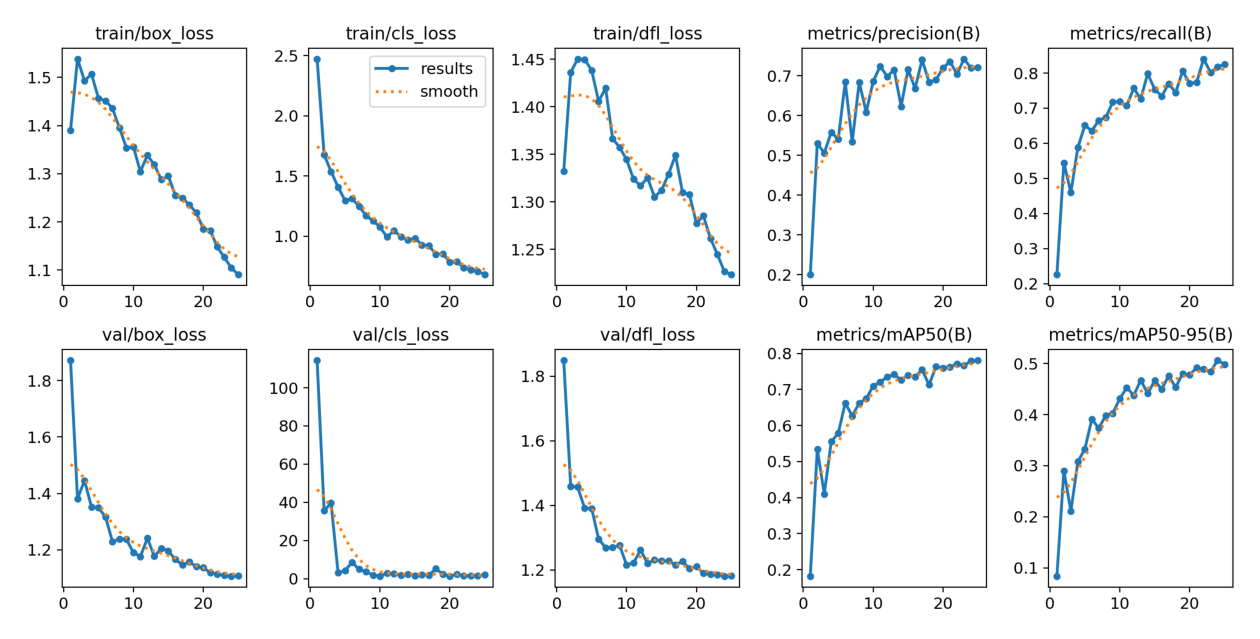

In [ ]:
import matplotlib.pyplot as plt

results = plt.imread('runs/detect/train/results.png')

plt.figure(figsize=(16, 10))
plt.imshow(results)
plt.axis('off')
plt.show()

> Estaría bien construir nuestras propias gráficas porque estas son muchas y hay información que podríamos obviar

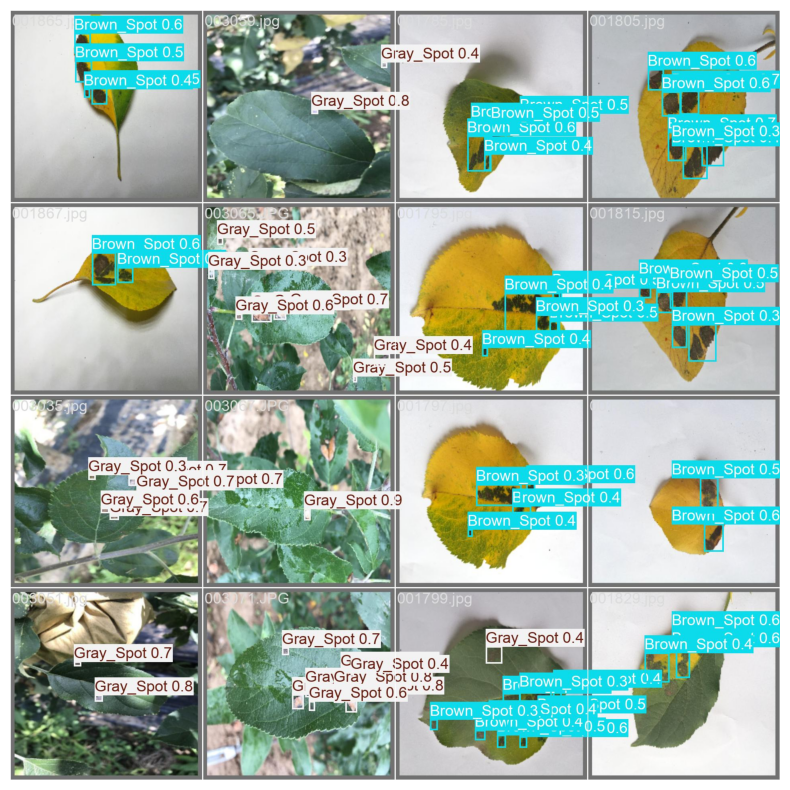

In [ ]:
val_sample = plt.imread('runs/detect/train/val_batch2_pred.jpg')

plt.figure(figsize=(16, 10))
plt.imshow(val_sample)
plt.axis('off')
plt.show()

### YOLOv3 Tiny

La versión `tiny` está diseñada para poder ejecutarse en dispositivos móviles y Raspberry Pis.

In [ ]:
tiny_model = YOLO('yolov3-tinyu.pt')

# Train the model for 3 epochs
tiny_results = tiny_model.train(
    data=YAML_PATH,
    epochs=25,
    imgsz=640,
    batch=16
)

# Evaluate the model's performance on the validation set
tiny_metrics = tiny_model.val()

Ultralytics 8.3.251 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (NVIDIA A100-SXM4-40GB, 40507MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/AppleTreeLeafDisease_YOLO/data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=25, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov3-tinyu.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=train5, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=100, 

In [ ]:
df2 = pd.read_csv("runs/detect/train5/results.csv")
df2.tail()

epoch     time  train/box_loss  train/cls_loss  train/dfl_loss  \
20     21  164.581         1.08103         0.68680         0.99964   
21     22  172.195         1.03645         0.64021         0.98475   
22     23  179.868         1.03046         0.63366         0.97604   
23     24  187.369         1.00946         0.63103         0.96401   
24     25  194.941         1.00661         0.60493         0.96304   

    metrics/precision(B)  metrics/recall(B)  metrics/mAP50(B)  \
20               0.73814            0.78877           0.77748   
21               0.73791            0.80180           0.76287   
22               0.72513            0.77552           0.76813   
23               0.71563            0.79798           0.77093   
24               0.74091            0.78084           0.77539   

    metrics/mAP50-95(B)  val/box_loss  val/cls_loss  val/dfl_loss    lr/pg0  \
20              0.47923       1.11514       1.10693       0.95296  0.000231   
21              0.48131       1.09018       1.12134       0.95156  0.000187   
22              0.47705       1.09913       1.30951       0.96439  0.000143   
23              0.48323       1.09451       1.17078       0.95386  0.000099   
24              0.48136       1.09838       1.40720       0.95826  0.000055   

      lr/pg1    lr/pg2  
20  0.000231  0.000231  
21  0.000187  0.000187  
22  0.000143  0.000143  
23  0.000099  0.000099  
24  0.000055  0.000055

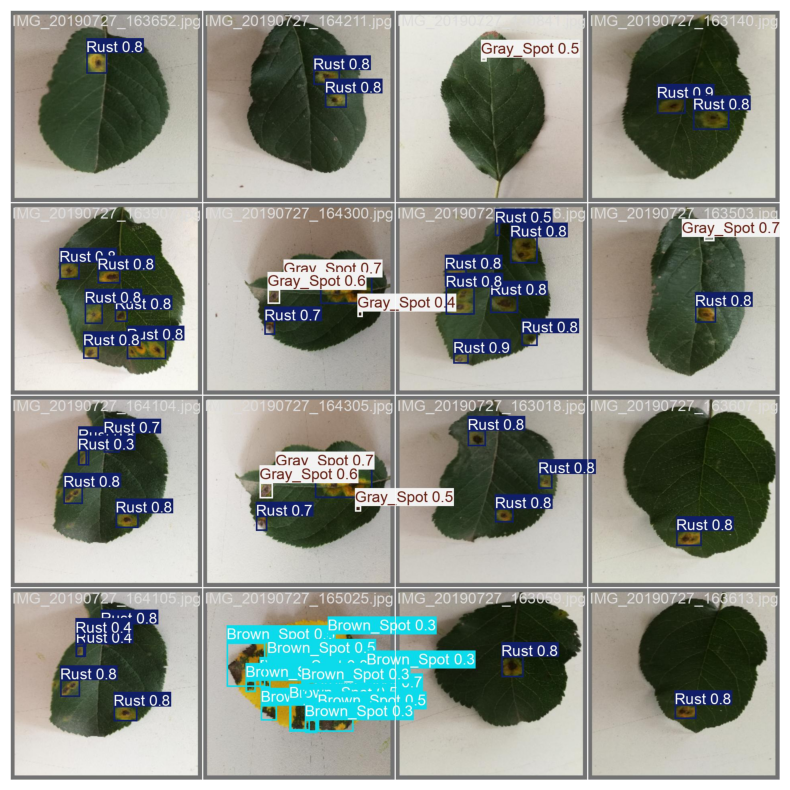

In [ ]:
tiny_val_sample = plt.imread('runs/detect/val3/val_batch0_pred.jpg')

plt.figure(figsize=(16, 10))
plt.imshow(tiny_val_sample)
plt.axis('off')
plt.show()